In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths

#path for training image
zip_file_path_training = '/content/drive/MyDrive/train_1_new_dataset.zip' #this should be training data.
extracted_folder_path_training = '/content/train_images'


#path for validating/(testing) images
zip_file_path_testing = '/content/drive/MyDrive/test_new_dataset.zip'
extracted_folder_path_testing = '/content/test_images'


# Extract the zip file
#for training
import zipfile
with zipfile.ZipFile(zip_file_path_training, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path_training)
#for testing
with zipfile.ZipFile(zip_file_path_testing, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path_testing)


Mounted at /content/drive


In [ ]:

import os
from numpy import asarray
from keras.preprocessing.image import img_to_array, load_img

#fixing the image input/output resolution
image_horizontal = 128
image_vertical = 128

def pair_images(masked_folder_path, unmasked_folder_path, size=(image_horizontal, image_vertical), max_images=8000): #max limit set to 8000 due to memory constraints
    src_list = []
    tar_list = []

    count = 0
    for filename in os.listdir(masked_folder_path):
        if count >= max_images:
            break

        masked_img_path = os.path.join(masked_folder_path, filename)
        masked_pixels = load_img(masked_img_path, target_size=size)
        masked_pixels = img_to_array(masked_pixels)
        src_list.append(masked_pixels)

        # Load corresponding unmasked image
        unmasked_img_path = os.path.join(unmasked_folder_path, filename)
        unmasked_pixels = load_img(unmasked_img_path, target_size=size)
        unmasked_pixels = img_to_array(unmasked_pixels)
        tar_list.append(unmasked_pixels)

        count += 1

        # Free up memory
        del masked_pixels
        del unmasked_pixels

    src_images = asarray(src_list)
    tar_images = asarray(tar_list)

    # Freeing up memory
    del src_list
    del tar_list

    return src_images, tar_images

# Defining paths
unmasked_path_training = '/content/train_images/train_1/train_original'
masked_path_training = '/content/train_images/train_1/train_masked'

unmasked_path_testing = '/content/test_images/test/test_original'
masked_path_testing = '/content/test_images/test/test_masked'

# Load paired images for training
src_images, tar_images = pair_images(masked_path_training, unmasked_path_training)

# Load paired images for testing
src_images_testing, tar_images_testing = pair_images(masked_path_testing, unmasked_path_testing)


Loaded:  (8000, 128, 128, 3) (8000, 128, 128, 3)


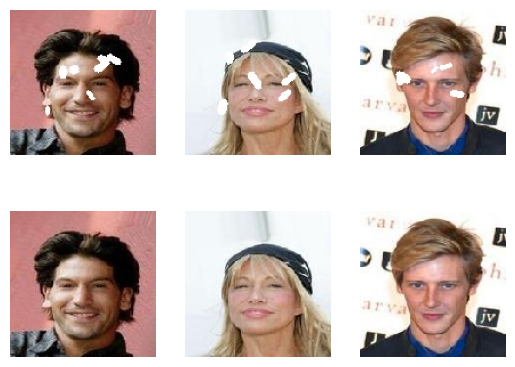

In [ ]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np

#for training set


print('Loaded: ', src_images.shape, tar_images.shape)
n_samples = 3
#plotting source image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plotting target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

Loaded:  (2000, 128, 128, 3) (2000, 128, 128, 3)


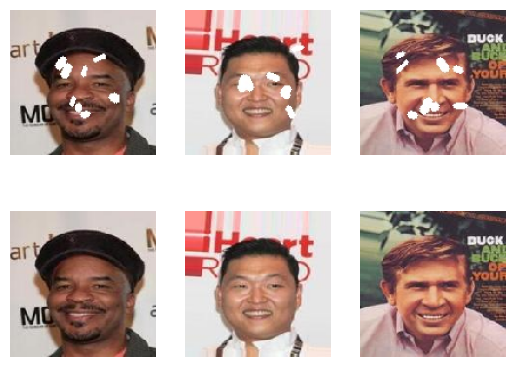

In [ ]:
#for testing set

from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np


print('Loaded: ', src_images_testing.shape, tar_images_testing.shape)
n_samples = 3
#plot source image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images_testing[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images_testing[i].astype('uint8'))
pyplot.show()

In [ ]:
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization

#discriminator architecture


def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)

    # source image input
    in_src_image = Input(shape=image_shape)

    # target image input
    in_target_image = Input(shape=image_shape)

    # concatenate images, channel-wise
    merged = Concatenate()([in_src_image, in_target_image])

    # C64: 4x4 kernel Stride 2x2
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)

    # C128: 4x4 kernel Stride 2x2
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    # C256: 4x4 kernel Stride 2x2
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    # C512: 4x4 kernel Stride 2x2
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    # C512: 4x4 kernel Stride 2x2
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Flatten layer
    d = Flatten()(d)

    # Fully connected layer
    d = Dense(1, activation='sigmoid')(d)

    # define model
    model = Model([in_src_image, in_target_image], d)

    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])

    return model

# Example usage:
disc_model = define_discriminator((image_horizontal, image_vertical, 3))
print(disc_model.summary())


In [ ]:
# for 128*128
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from keras.utils import plot_model



#generator architecture

def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block to be used in generator
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

image_horizontal=128
image_vertical=128

# define the standalone generator model - U-net
def define_generator(image_shape=(image_horizontal,image_vertical,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	# e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e6)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e6, 512)
	d2 = decoder_block(d1, e5, 512)
	d3 = decoder_block(d2, e4, 512,dropout=False) #recently changed
	d4 = decoder_block(d3, e3, 256, dropout=False)
	d5 = decoder_block(d4, e2, 128, dropout=False)
	d6 = decoder_block(d5, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d6) #Modified
	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	# define model
	model = Model(in_image, out_image)
	return model

gen_model = define_generator((image_horizontal,image_vertical,3))
# plot_model(gen_model, to_file='gen_model.png', show_shapes=True)
gen_model.summary()


In [ ]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but
                                                #standalone descriminator will be trainable.

	# define the source image
	in_src = Input(shape=image_shape)
	# suppy the image as input to the generator
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)

    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #weighting BCE vs L1 as 1:100.
	model.compile(loss=['binary_crossentropy', 'mae'],
               optimizer=opt, loss_weights=[1,100])

	return model

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

import numpy as np


# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), 1))
    return X, y


def summarize_performance(step, g_model, dataset, n_samples=3):  #performance on training data when the model is being trained.
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA)

    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])

    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])

    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_training_data_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()




def performance_on_testing_data(step, g_model, dataset_testing, n_samples=3):  #performamce in validation ( testing ) data
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset_testing, n_samples)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA)



    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])

    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])

    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_testing_data_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()

def saving_models(g_model, d_model, gan_model,step): #saving 3 models for loading them back in the future
    # save the generator model
    filename1 = 'generator_model_%06d.h5' % (step+1)
    g_model.save(filename1)
    print('>Saved: %s' % (filename1))

    filename2 = 'd_model_%06d.h5' % (step+1)
    d_model.save(filename2)
    print('>Saved: %s' % ( filename2))

def loss_training_testing(step, g_model, dataset_testing, dataset, n_samples=1): #calcultate loss on traiining and testing data by averaging loss for 5 images
    training_losses = []
    testing_losses = []

    # Calculate training data loss
    for _ in range(6):
        [X_realA_train, X_realB_train], _ = generate_real_samples(dataset, n_samples)
        X_fakeB_train, _ = generate_fake_samples(g_model, X_realA_train)
        training_losses.append(np.mean(np.abs(X_realB_train - X_fakeB_train)))

    training_loss = np.mean(training_losses)
    print('')
    print('>%d, training_loss[%.3f]' % (step+1, training_loss))

    # Calculate testing data loss
    for _ in range(6):
        [X_realA_test, X_realB_test], _ = generate_real_samples(dataset_testing, n_samples)
        X_fakeB_test, _ = generate_fake_samples(g_model, X_realA_test)
        testing_losses.append(np.mean(np.abs(X_realB_test - X_fakeB_test)))

    testing_loss = np.mean(testing_losses)
    print('')
    print('>%d, testing_loss[%.3f]' % (step+1, testing_loss))

    return training_loss * 100, testing_loss * 100  # to amplify the errors




def plot_losses(steps, d1_losses, d2_losses, g_losses):
    plt.plot(steps, d1_losses, label='Discriminator Loss 1')
    plt.plot(steps, d2_losses, label='Discriminator Loss 2')
    plt.plot(steps, g_losses, label='Generator Loss')
    plt.xlabel('batches')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.show()


def plot_training_testing_losses(steps,training_mae,testing_mae): #comparetive loss visualizaion
    plt.plot(steps,training_mae, label='training_mae')
    plt.plot(steps, testing_mae, label='testing_mae')
    plt.xlabel('after each 50 steps')
    plt.ylabel('Loss')
    plt.title('Training testing Losses')
    plt.legend()
    plt.show()




# train pix2pix models
def train(d_model, g_model, gan_model, dataset, dataset_testing, n_epochs, n_batch):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs

    d1_losses, d2_losses, g_losses = [], [], []
    training_mae, testing_mae=[],[]

    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

        d1_losses.append(d_loss1)
        d2_losses.append(d_loss2)
        g_losses.append(g_loss)

        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 1) == 0:  # *10 originally #here this multiplicand determines how frequent to save a model
            performance_on_testing_data(i, g_model, dataset_testing)
            summarize_performance(i, g_model, dataset)
            saving_models(g_model, d_model, gan_model,i)


        if (i+1)%200 ==0:
            training_loss, testing_loss=loss_training_testing(i, g_model, dataset_testing, dataset,  n_samples=1)
            training_mae.append(training_loss)
            testing_mae.append(testing_loss)
        if (i+1)%(bat_per_epo/8)==0:
            plot_losses(range(1, len(d1_losses) + 1), d1_losses, d2_losses, g_losses)
            plot_training_testing_losses(range(1, len(training_mae) + 1),training_mae,testing_mae)  #plotting early as session crashes must of the time
    plot_losses(range(1, len(d1_losses) + 1), d1_losses, d2_losses, g_losses)
    plot_training_testing_losses(range(1, len(training_mae) + 1),training_mae,testing_mae)








In [ ]:
image_shape = src_images.shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

#Define data
# load and prepare training images
data = [src_images, tar_images]

#preparing testing images
data_testing=[src_images_testing,tar_images_testing]

def preprocess_data(data):
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)
dataset_testing=preprocess_data(data_testing)

from datetime import datetime
start1 = datetime.now()
train(d_model, g_model, gan_model, dataset, dataset_testing, n_epochs=2, n_batch=1)

stop1 = datetime.now()
#Execution time of the model
execution_time = stop1-start1
print("Execution time is: ", execution_time)



1/1 [==============================] - 0s 491ms/step


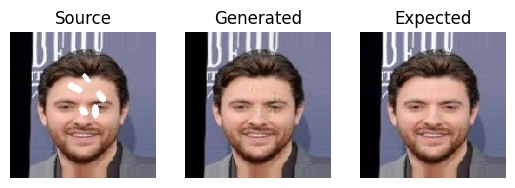

In [ ]:
#Test trained model on training images...

from keras.models import load_model
from numpy.random import randint
model = load_model('generator_model_016000.h5')
from numpy import vstack
# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()



[X1, X2] = dataset
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

1/1 [==============================] - 0s 358ms/step


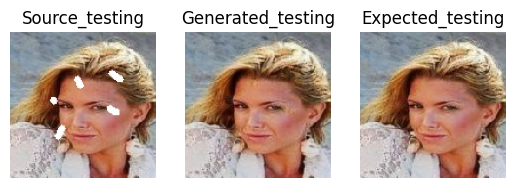

In [ ]:
#Test trained model on testing images
from numpy import vstack
from keras.models import load_model
from numpy.random import randint
model = load_model('generator_model_016000.h5')

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source_testing', 'Generated_testing', 'Expected_testing']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()



[X1, X2] = dataset_testing
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)